### Load Data

In [1]:
model_name = 'z_model_siamese_lin'
num_epochs = 50

In [2]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import DenseGCNConv, dense_diff_pool
from torch_geometric.utils import dense_to_sparse
import math
import numpy as np

In [3]:
data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
#data_dir_1 = 'C:/Users/thoma/OneDrive - ZHAW/ProteinSurfaces-DESKTOP-AQ00763/patch_label_1'
#data_dir_0 = 'C:/Users/thoma/OneDrive - ZHAW/ProteinSurfaces-DESKTOP-AQ00763/patch_label_0'

In [4]:
from c_PatchDataset import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [5]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs pairs: {len(dataset)}')

data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes in each: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')


Dataset: PatchDataset(572):
Number of graphs pairs: 572

PairData(adj1=[100, 100], x1=[100, 3], adj2=[100, 100], x2=[100, 3], y=1)
Number of nodes in each: None
Number of node features: 0


c:\Users\david\pyproj\pyg\pyg_env\lib\site-packages\torch_geometric\data\storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'adj1', 'adj2', 'x2', 'x1'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [6]:
data.x2

tensor([[ 0.5771,  0.6504, -0.4940],
        [ 0.1989,  0.0000, -0.9800],
        [ 0.1509,  0.0309,  0.9881],
        [ 0.1532,  0.0000, -0.9882],
        [ 0.0752,  0.0075,  0.9971],
        [-0.0100,  0.0000,  0.9999],
        [-0.0288,  0.0000, -0.9996],
        [-0.0378,  0.0000, -0.9993],
        [-0.0106,  0.0000,  0.9999],
        [-0.6231, -0.0664, -0.7793],
        [-0.0183,  0.0000, -0.9998],
        [ 0.1648,  0.0000,  0.9863],
        [-0.0215,  0.0000,  0.9998],
        [-0.0094,  0.0000,  1.0000],
        [ 0.0509,  0.0000, -0.9987],
        [-0.2971, -0.1559,  0.9420],
        [ 0.0022,  0.0000,  1.0000],
        [ 0.0945,  0.0947,  0.9910],
        [ 0.0015,  0.0000,  1.0000],
        [-0.0087,  0.0000,  1.0000],
        [ 0.5470,  0.0000,  0.8371],
        [ 0.7824,  0.0169, -0.6225],
        [-0.6867,  0.0000,  0.7269],
        [ 0.0950,  0.0000, -0.9955],
        [ 0.0333,  0.0000,  0.9994],
        [-0.0141,  0.0000,  0.9999],
        [ 0.0418,  0.0000,  0.9991],
 

In [7]:
# Does not work we do not have pos
#visualize_points(data.pos, data.edge_index)

In [8]:
from torch_geometric.loader import DataLoader 

batch_size = 1

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [9]:
databatch = next(iter(train_loader))
databatch

PairDataBatch(adj1=[100, 100], x1=[100, 3], adj2=[100, 100], x2=[100, 3], y=[1])

## Define Network

In [10]:
class GNN(torch.nn.Module):
    def __init__(self, in_nodes, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        # Each instance of this GNN will have 3 convolutional layers and three batch norm layers        
        self.conv1 = DenseGCNConv(in_channels, hidden_channels, normalize)
        self.bns1 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv2 = DenseGCNConv(hidden_channels, hidden_channels, normalize)
        self.bns2 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv3 = DenseGCNConv(hidden_channels, out_channels, normalize)
        self.bns3 = torch.nn.BatchNorm1d(in_nodes)


    def forward(self, x, adj, mask=None):
        
        #Step 1
        x = self.conv1(x, adj, mask)
        x = self.bns1(x)
        
        #Step 2
        x = self.conv2(x, adj, mask)
        x = self.bns2(x)

        #Step 3
        x = self.conv3(x, adj, mask)
        if x.shape[2] != 1: 
            x = self.bns3(x)

        return x


class DiffPool(torch.nn.Module):
    def __init__(self, num_nodes):
        super(DiffPool, self).__init__()

        #Hierarchical Step #1
        in_nodes = num_nodes
        out_nodes = 25 # Number of clusters / nodes in the next layer
        self.gnn1_pool = GNN(in_nodes, dataset.num_features, 16, out_nodes) # PoolGNN --> Cluster Assignment Matrix to reduce to num_nodes
        self.gnn1_embed = GNN(in_nodes, dataset.num_features, 8, 8) # EmbGNN --> Convolutions to create new node embedding

        # Hierarchical Step #2
        in_nodes = out_nodes
        out_nodes = 10
        self.gnn2_pool = GNN(in_nodes, 8, 8, out_nodes)
        self.gnn2_embed = GNN(in_nodes, 8, 8, 16, lin=False)

        # Hierarchical Step #3
        in_nodes = out_nodes
        out_nodes = 1
        self.gnn3_pool = GNN(in_nodes, 16, 8, out_nodes)
        self.gnn3_embed = GNN(in_nodes, 16, 16, 32, lin=False)

        # Final Classifier
        self.lin1 = torch.nn.Linear(32, 64) 
        self.lin2 = torch.nn.Linear(64, 96)



    def forward(self, x, adj):
        
        #Hierarchical Step #1
        x1 = self.gnn1_embed(x, adj) # node feature embedding
        s = self.gnn1_pool(x, adj) # cluster assignment matrix

        x, adj, l1, e1 = dense_diff_pool(x1, adj, s) # does the necessary matrix multiplications
        adj = torch.softmax(adj, dim=-1)


        # Hierarchical Step #2
        x2 = self.gnn2_embed(x, adj)
        s = self.gnn2_pool(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x2, adj, s)
        adj = torch.softmax(adj, dim=-1)

      
        # Hierarchical Step #3
        x3 = self.gnn3_embed(x, adj)
        s = self.gnn3_pool(x, adj)
        
        x, adj, l3, e3 = dense_diff_pool(x3, adj, s)
        adj = torch.softmax(adj, dim=-1)     
        

        x = x.mean(dim=1) 

        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        
        return x

### Contrastive Loss Function

In [11]:
# An attempt of a contrastive loss function
#   pairs with label 1 --> should get small euclid dist = small loss
#   pairs with label 0 --> should get large euclid dist = small loss

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):

        diff = x0 - x1
        pow = torch.pow(diff, 2)
        dist_sq = torch.sum(pow, 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin- dist

        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)

        return loss

### Training

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = DiffPool(num_nodes = 100).to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output1 = model(data.x1, data.adj1)
        output2 = model(data.x2, data.adj2)
        
        #Contrastive Loss
        loss_contrastive = criterion(output1,output2,data.y)
        loss_contrastive.backward()
        loss_all += data.y.size(0) * loss_contrastive.item()
        optimizer.step()

    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    distances_lab1 = []
    distances_lab0 = []
    loss_all = 0
    
    for data in loader:
        data = data.to(device)
        output1 = model(data.x1, data.adj1)
        output2 = model(data.x2, data.adj2)

        loss = criterion(output1, output2, data.y)
        euclidean_distance = F.pairwise_distance(output1, output2)
        label = data.y

        if int(label) == 1: 
            distances_lab1.append(float(euclidean_distance))
            loss_all += float(loss)
        else:
            distances_lab0.append(float(euclidean_distance))
            loss_all += float(loss)

    return  distances_lab0, distances_lab1, loss_all/(len(loader)*batch_size)



# Initialize data collections
#==============================================================================================================================

train_distances_lab0 = []
train_distances_lab1 = []
train_losses = []

validation_distances_lab0 = []
validation_distances_lab1 = []
validation_losses = []

test_distances_lab0 = []
test_distances_lab1 = []
test_losses = []

val_dists_0 = []
val_dists_1 = []
train_dists_0 = []
train_dists_1 = []

with open(f'{model_name}_printout.txt', 'w') as f:
    f.write(f'Training Data ({model_name}):\n')
    f.close()
#==============================================================================================================================



# Test and Validation Data before Training
#==============================================================================================================================
train_results = test(train_loader)
train_distances_lab0.append(train_results[0])
train_distances_lab1.append(train_results[1])
train_losses.append(train_results[2])

validation_results = test(val_loader)
validation_distances_lab0.append(validation_results[0])
validation_distances_lab1.append(validation_results[1])
validation_losses.append(validation_results[2])

test_results = test(test_loader)
test_distances_lab0.append(test_results[0])
test_distances_lab1.append(test_results[1])
test_losses.append(test_results[2])

min_val_loss = (validation_results[2]+test_results[2])/2
#==============================================================================================================================


# Compute Euclidean Distances for printout
#==============================================================================================================================
val_dist_0 = test_results[0] + validation_results[0] # List of all euclidean distances of label 0 members of val and test dataset
val_dist_1 = test_results[1] + validation_results[1] # List of all euclidean distances of label 1 members of val and test dataset
# Ratio (mean label 0 euclid dist in validation set / mean label 1 euclid dist in validation set)
val_dist_ratio = (sum(val_dist_0) / len(val_dist_0)) / (sum(val_dist_1) / len(val_dist_1))
best_dist_ratio = val_dist_ratio
val_dists_0.append(sum(val_dist_0) / len(val_dist_0))
val_dists_1.append(sum(val_dist_1) / len(val_dist_1))

train_dist_0 = train_results[0] # List of all euclidean distances of label 0 members of train dataset
train_dist_1 = train_results[1] # List of all euclidean distances of label 0 members of train dataset
# Ratio of (mean label 0 euclid dist in training set / mean label 1 euclid dist in training set)
train_dist_ratio = (sum(train_dist_0) / len(train_dist_0)) / (sum(train_dist_1) / len(train_dist_1))
train_dists_0.append(sum(train_dist_0) / len(train_dist_0))
train_dists_1.append(sum(train_dist_1) / len(train_dist_1))
#===============================================================================================================================

printout = (f'Before Tr:  Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
            f'ValDistanceRatio (L0/L1): {(val_dist_ratio):.3f}, TrainDistanceRatio (L0/L1): {(train_dist_ratio):.3f}')

print(printout)

# append to outputs txt
with open(f'{model_name}_printout.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()



#===============================================================================================================================================
# Training
#===============================================================================================================================================

for epoch in range(1, num_epochs+1):
    
    train_loss = train(epoch)


    # Test and Validation Data During Training
    #===============================================================================================================================================
    train_results = test(train_loader)
    train_distances_lab0.append(train_results[0])
    train_distances_lab1.append(train_results[1])
    train_losses.append(train_results[2])

    validation_results = test(val_loader)
    validation_distances_lab0.append(validation_results[0])
    validation_distances_lab1.append(validation_results[1])
    validation_losses.append(validation_results[2])

    test_results = test(test_loader)
    test_distances_lab0.append(test_results[0])
    test_distances_lab1.append(test_results[1])
    test_losses.append(test_results[2])

    #===============================================================================================================================================


    # Compute Euclidean Distances for printout
    #==============================================================================================================================
    val_dist_0 = test_results[0]+validation_results[0] # List of all euclidean distances of label 0 members of val and test dataset
    val_dist_1 = test_results[1]+validation_results[1] # List of all euclidean distances of label 1 members of val and test dataset
    # Ratio (mean label 0 euclid dist in validation set / mean label 1 euclid dist in validation set)
    val_dist_ratio = (sum(val_dist_0) / len(val_dist_0)) / (sum(val_dist_1) / len(val_dist_1))
    val_dists_0.append(sum(val_dist_0) / len(val_dist_0))
    val_dists_1.append(sum(val_dist_1) / len(val_dist_1))

    train_dist_0 = train_results[0] # List of all euclidean distances of label 0 members of train dataset
    train_dist_1 = train_results[1] # List of all euclidean distances of label 0 members of train dataset
    # Ratio of (mean label 0 euclid dist in training set / mean label 1 euclid dist in training set)
    train_dist_ratio = (sum(train_dist_0) / len(train_dist_0)) / (sum(train_dist_1) / len(train_dist_1))
    train_dists_0.append(sum(train_dist_0) / len(train_dist_0))
    train_dists_1.append(sum(train_dist_1) / len(train_dist_1))
    #===============================================================================================================================
    


    # Create Printout
    #===============================================================================================================================================
    #printout = (f'Epoch: {epoch:03d}, Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
    #        f'ValDist 0: {val_dist_0:.3f}, ValDist 1: {val_dist_1:.3f}, TrainDist 0: {train_dist_0:.3f}, TrainDist 1: {train_dist_1:.3f}')
    printout = (f'Epoch: {epoch:03d}, Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
            f'ValDistanceRatio (L0/L1): {(val_dist_ratio):.3f}, TrainDistanceRatio (L0/L1): {(train_dist_ratio):.3f}')
    print(printout)

    # append to outputs txt
    with open(f'{model_name}_printout.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()
    #===============================================================================================================================================



    # Save the model outputs
    #===============================================================================================================================================
    np.save(f'{model_name}_training_loss.npy', train_losses, allow_pickle=True)
    np.save(f'{model_name}_training_distances_lab0.npy', train_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_training_distances_lab1.npy', train_distances_lab1, allow_pickle=True)

    np.save(f'{model_name}_validation_loss.npy', validation_losses, allow_pickle=True)
    np.save(f'{model_name}_validation_distances_lab0.npy', validation_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_validation_distances_lab1.npy', validation_distances_lab1, allow_pickle=True)

    np.save(f'{model_name}_test_loss.npy', test_losses, allow_pickle=True)
    np.save(f'{model_name}_test_distances_lab0.npy', test_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_test_distances_lab1.npy', test_distances_lab1, allow_pickle=True)
    
    last_saved_epoch = epoch
    #===============================================================================================================================================


    # If the epoch has improved the model, save it
    if val_dist_ratio > best_dist_ratio:
        new_best = True
        best_dist_ratio = val_dist_ratio
        best_epoch = epoch
    else:
        new_best = False
        
    if new_best:
        torch.save(model.state_dict(), f'{model_name}_state_dict_best.pt')
        torch.save(model, f'{model_name}_save.pt')

cpu
Before Tr:  Train Loss: 55.246, Val Loss: 60.682, Test Loss: 54.160, ValDistanceRatio (L0/L1): 1.462, TrainDistanceRatio (L0/L1): 1.445
Epoch: 001, Train Loss: 197.508, Val Loss: 262.304, Test Loss: 198.129, ValDistanceRatio (L0/L1): 1.290, TrainDistanceRatio (L0/L1): 1.278
Epoch: 002, Train Loss: 64.147, Val Loss: 108.893, Test Loss: 50.116, ValDistanceRatio (L0/L1): 1.719, TrainDistanceRatio (L0/L1): 1.856
Epoch: 003, Train Loss: 111.369, Val Loss: 160.094, Test Loss: 75.542, ValDistanceRatio (L0/L1): 1.954, TrainDistanceRatio (L0/L1): 2.131
Epoch: 004, Train Loss: 317.369, Val Loss: 368.770, Test Loss: 329.185, ValDistanceRatio (L0/L1): 1.136, TrainDistanceRatio (L0/L1): 1.097
Epoch: 005, Train Loss: 217.324, Val Loss: 281.443, Test Loss: 177.846, ValDistanceRatio (L0/L1): 1.785, TrainDistanceRatio (L0/L1): 1.914
Epoch: 006, Train Loss: 264.714, Val Loss: 342.791, Test Loss: 279.276, ValDistanceRatio (L0/L1): 1.043, TrainDistanceRatio (L0/L1): 1.003
Epoch: 007, Train Loss: 60.96

### Evaluation

In [13]:
best_epoch, last_saved_epoch

(12, 50)

In [14]:
import matplotlib.pyplot as plt

def compare_euclid_distances(distances_lab0, distances_lab1, save=None, title=None):

    '''Function for plotting the euclidean distances of two datasets generated during a model epoch'''

    w = 0.8    # bar width
    x = [1, 2] # x-coordinates of your bars
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors

    # Epoch 0
    y = [distances_lab0, distances_lab1]


    fig, ax = plt.subplots()
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=[np.std(yi) for yi in y],    # error bars
        capsize=12, # error bar cap width in points
        width=w,    # bar width
        tick_label=["Label 0", "Label 1"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=colors,
        )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        ax.scatter(x[i] + np.random.random(len(y[i])) * w - w / 2, y[i], color=colors[i])

    plt.title(title)
    plt.ylabel('Euclidean Distance')
    #plt.ylim(top=1.5, bottom=0)
    
    if save != None:
        plt.savefig(save)
    plt.show()


### Compare Euclidean Distances in the Training Set (Before and after Training)

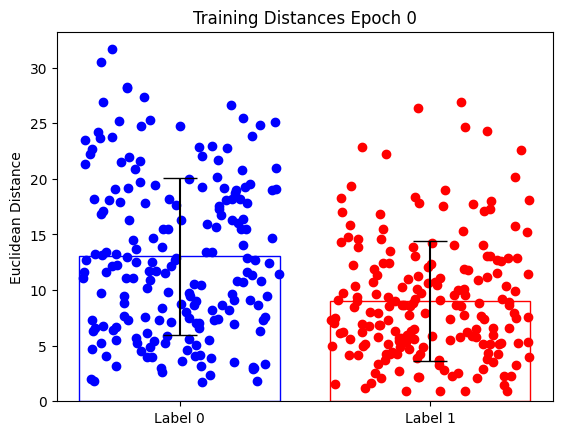

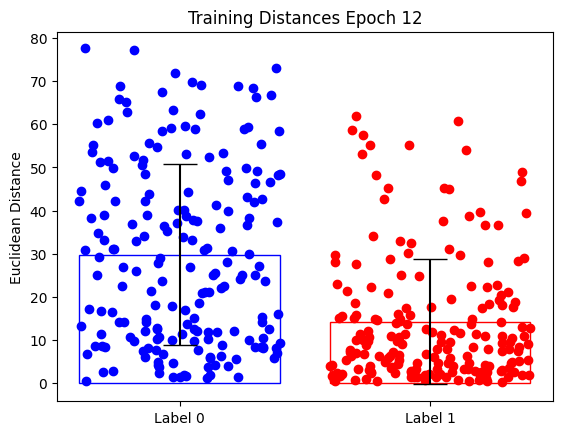

In [15]:
compare_euclid_distances(train_distances_lab0[0], train_distances_lab1[0], save = model_name + '_plot_train_dist0.png', title = 'Training Distances Epoch 0')
compare_euclid_distances(train_distances_lab0[best_epoch], train_distances_lab1[best_epoch], save = model_name + f'_plot_train_dist_{best_epoch}', title = f'Training Distances Epoch {best_epoch}')

### Compare Euclidean Distances in the Validation Set (Before and after Training)

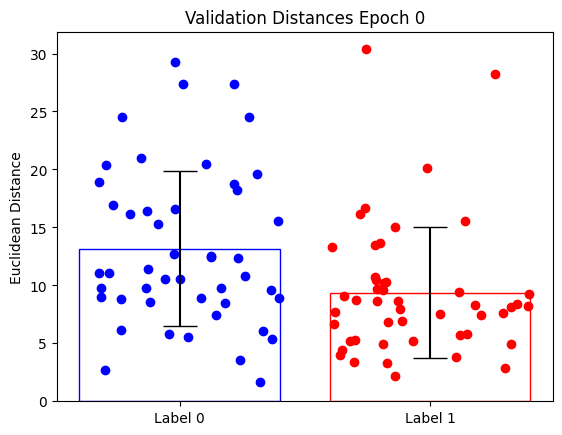

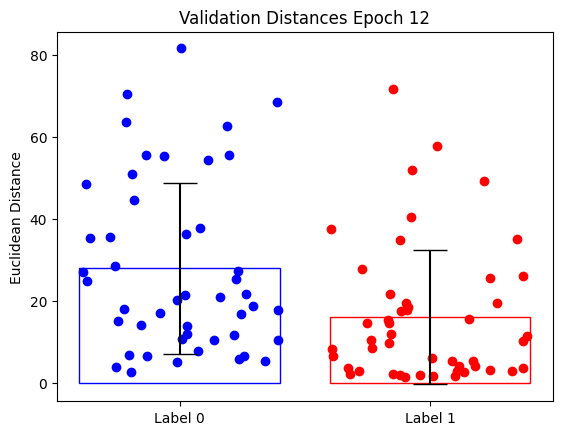

In [16]:
compare_euclid_distances(validation_distances_lab0[0], validation_distances_lab1[0], save = model_name + '_plot_val_dist0.png', title = 'Validation Distances Epoch 0')
compare_euclid_distances(validation_distances_lab0[best_epoch], validation_distances_lab1[best_epoch], save = model_name + f'_plot_val_dist_{best_epoch}', title = f'Validation Distances Epoch {best_epoch}')

### Plot Training and Validation Losses

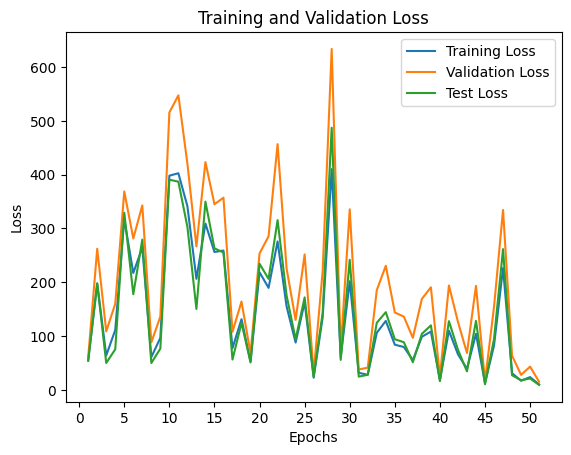

In [17]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+2)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_loss.png')
#plt.ylim(top=60, bottom = 0)
plt.show()


### Plot Euclidean Distances (Label0 vs. Label1)

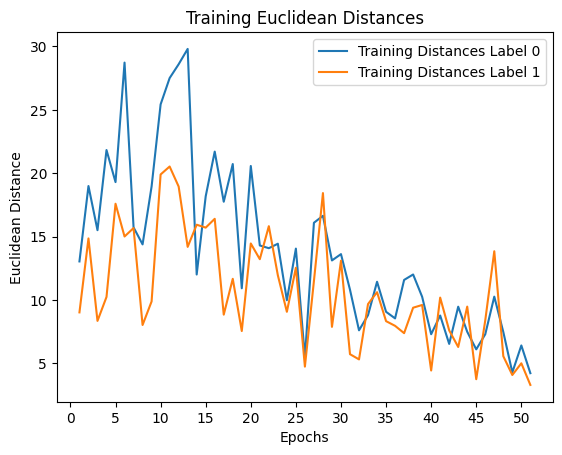

In [18]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+2)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_dists_0, label='Training Distances Label 0')
plt.plot(epochs, train_dists_1, label='Training Distances Label 1')
 
# Add in a title and axes labels
plt.title('Training Euclidean Distances')
plt.xlabel('Epochs')
plt.ylabel('Euclidean Distance')

 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_train_distances.png')
#plt.ylim(top=60, bottom = 0)
plt.show()